In [45]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
import scienceplots

import candel
from candel import SPEED_OF_LIGHT

from utils import *

from scipy.stats import norm
from astropy.cosmology import FlatLambdaCDM
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

root = "/Users/rstiskalek/Projects/CANDEL/results/CH0"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
with File("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/los_SH0ES_TFR_Carrick2015.hdf5", 'r') as f:
    r_C15 = f["r"][...]
    los_density_C15 = f["los_density"][...]
    los_velocity_C15 = f["los_velocity"][...]

with File("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/los_SH0ES_TFR_manticore_2MPP_MULTIBIN_N256_DES_V2.hdf5", 'r') as f:
    r_Manticore = f["r"][...]
    los_density_Manticore = f["los_density"][...]
    los_velocity_Manticore = f["los_velocity"][...]

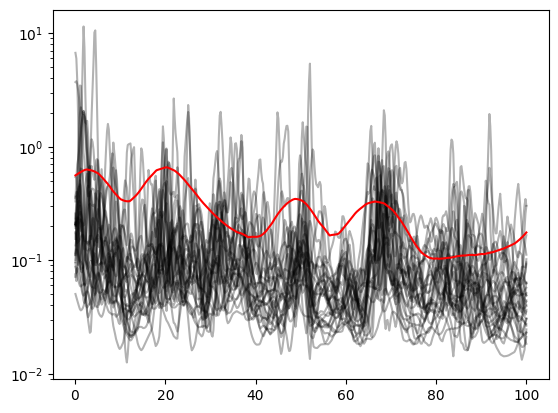

In [66]:
k = 10

plt.figure()
for n in range(30):
    plt.plot(r_Manticore, los_density_Manticore[n, k] / 275.4, c="black", alpha=0.3)
plt.plot(r_C15, 0.43 * los_density_C15[0, k], c="red")
plt.yscale("log")
plt.show()

In [46]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path)

2025-07-17 09:13:07 warning: zero width found in the priors. Setting it to 1e-5.
2025-07-17 09:13:07 indices of zero width: [44]
2025-07-17 09:13:07 found zero-width prior at index 44. Setting it to 0.
2025-07-17 09:13:07 normalizing the Manticore LOS density.


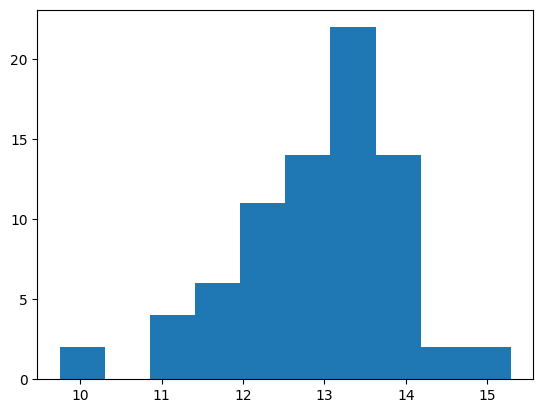

In [4]:
plt.figure()
plt.hist(data["Y_SN_Cepheid"], bins="auto")
plt.show()

In [5]:
mu_host_r2 = read_samples(root, "Cepheid_distances_r2_prior.hdf5", "mu_host")

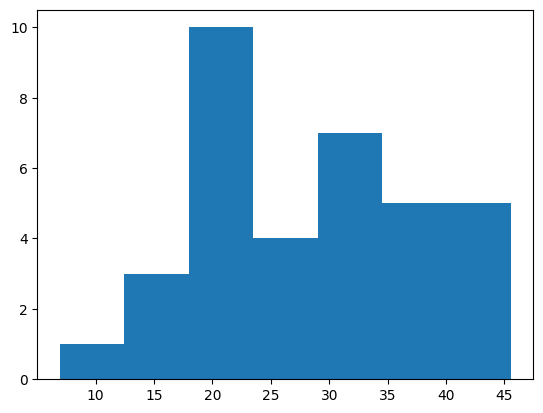

In [6]:
mu = np.mean(mu_host_r2, axis=0)

r = 10**(mu_host_r2 / 5 - 5)

r = np.mean(r, axis=0)


r = r[r < 50]

# r = r.flatten()



plt.figure()
plt.hist(r, bins="auto")
plt.show()

### Cepheid-magnitude relation

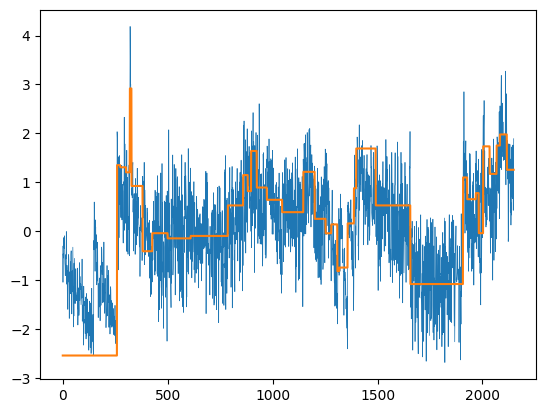

In [ ]:
L = data["L_SN_Cepheid_dist"]
Y = data["Y_SN_Cepheid"]


mag_SN = np.zeros(40)
unique_ks = []
for i in range(len(Y)):
    j = np.where(L[i] == 1)[0][0]

    if mag_SN[j] == 0:
        mag_SN[j] = Y[i]
        unique_ks.append(i)

unique_ks = np.asarray(unique_ks)



mag_SN_per_Cepheid = data["L_Cepheid_host_dist"] @ mag_SN
mag_Cepheid = data["mag_cepheid"]

m = mag_SN_per_Cepheid > 0
mag_SN_per_Cepheid = mag_SN_per_Cepheid[m]
mag_Cepheid = mag_Cepheid[m]

plt.figure()
plt.plot(mag_Cepheid - np.mean(mag_Cepheid), lw=0.5)
plt.plot(mag_SN_per_Cepheid - np.mean(mag_SN_per_Cepheid))

# plt.plot(mag_Cepheid )
# plt.plot(mag_SN_per_Cepheid )

plt.show()



### Redshift distribution

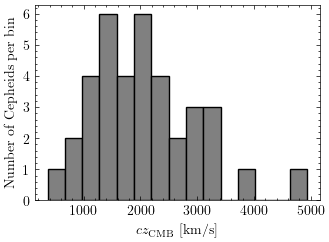

In [14]:

with plt.style.context("science"):
    plt.figure()
    plt.hist(data["czcmb_cepheid_host"], bins=15, color='gray', edgecolor='black')
    plt.xlabel(r"$cz_{\rm CMB} ~ [\mathrm{km} / \mathrm{s}]$")
    plt.ylabel("Number of Cepheids per bin")

    plt.tight_layout()
    plt.savefig(f"/Users/rstiskalek/Downloads/cepheid_host_czcmb_hist.pdf")
    plt.show()

### Hubble diagrams Cepheid-only Hubble diagrams

In [53]:
# Read-in the data
mu_host_r2 = read_samples(root, "Cepheid_distances_no_redshift_r2_mu.hdf5", "mu_host")
mu_host_r2_mag_sel = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5", "mu_host")
mu_host_unif = read_samples(root, "Cepheid_distances_no_redshift_uniform_mu.hdf5","mu_host")


mu_host_r2_mean = np.mean(mu_host_r2, axis=0)
mu_host_r2_mag_sel_mean = np.mean(mu_host_r2_mag_sel, axis=0)
mu_host_unif_mean = np.mean(mu_host_unif, axis=0)

mu_host_r2_err = np.std(mu_host_r2, axis=0)
mu_host_r2_mag_sel_err = np.std(mu_host_r2_mag_sel, axis=0)
mu_host_unif_err = np.std(mu_host_unif, axis=0)

cz = data["czcmb_cepheid_host"]
cz_err = np.ones_like(cz) * 250

In [56]:
mu_host_r2_mag_sel_err

array([0.04021071, 0.08636402, 0.08936174, 0.06299878, 0.13791788,
       0.05315252, 0.05509025, 0.03787941, 0.05355174, 0.06108897,
       0.06565281, 0.11512244, 0.09815054, 0.12916785, 0.06236743,
       0.04757381, 0.03606686, 0.06495961, 0.06879918, 0.05893011,
       0.08227991, 0.10919834, 0.04939785, 0.07307228, 0.1478966 ,
       0.05734346, 0.0482088 , 0.0498797 , 0.14625688, 0.0772839 ,
       0.07919829, 0.10396837, 0.07325421, 0.09104985, 0.08498459,
       0.09766931, 0.05810081], dtype=float32)

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_16257/1803591438.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


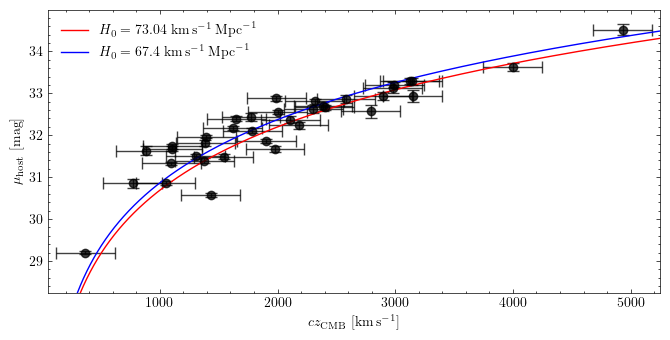

In [63]:
# Prepare the Hubble diagram plots
czrange = np.linspace(300, 5250, 1000)
zrange = czrange / SPEED_OF_LIGHT

cosmo_SH0ES = FlatLambdaCDM(H0=73.04, Om0=0.3)
mu_SH0ES = cosmo_SH0ES.distmod(czrange / SPEED_OF_LIGHT).value

cosmo_Planck = FlatLambdaCDM(H0=67.4, Om0=0.3)
mu_Planck = cosmo_Planck.distmod(czrange / SPEED_OF_LIGHT).value


# Compute SH0ES and Planck model predictions at the data cz points
mu_SH0ES_cz = np.interp(cz, czrange, mu_SH0ES)
mu_Planck_cz = np.interp(cz, czrange, mu_Planck)


m = cz < 5200

with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(6.8, 3.5))

    # Main panel
    # ax.errorbar(
    #     cz[m], mu_host_r2_mean[m], xerr=cz_err[m], yerr=mu_host_r2_err[m],
    #     fmt="o", color="black", capsize=4, alpha=0.75
    # )
    ax.errorbar(
        cz[m], mu_host_r2_mag_sel_mean[m], xerr=cz_err[m], yerr=mu_host_r2_mag_sel_err[m],
        fmt="o", color="black", capsize=4, alpha=0.75
    )

    ax.plot(
        czrange, mu_SH0ES, color="red",
        label=r"$H_0 = 73.04~\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$"
    )
    ax.plot(
        czrange, mu_Planck, color="blue",
        label=r"$H_0 = 67.4~\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$"
    )

    ax.set_xlabel(r"$c z_{\rm CMB} ~ [\mathrm{km}\,\mathrm{s}^{-1}]$")
    ax.set_ylabel(r"$\mu_{\rm host} ~ [\mathrm{mag}]$")
    ax.set_xlim(50, 5250)
    ax.set_ylim(mu_Planck.min())
    # ax.set_xscale("log")
    ax.legend()

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/mu_host_cz.pdf", dpi=500, bbox_inches="tight")
    fig.show()

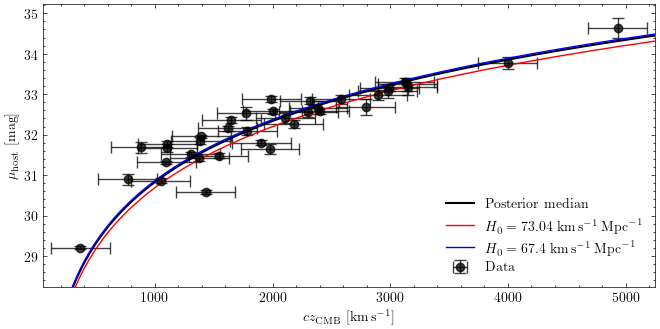

In [45]:
# Prepare the Hubble diagram grid
czrange = np.linspace(300, 5250, 1000)
zrange = czrange / SPEED_OF_LIGHT

cosmo_SH0ES = FlatLambdaCDM(H0=73.04, Om0=0.3)
mu_SH0ES = cosmo_SH0ES.distmod(zrange).value

cosmo_Planck = FlatLambdaCDM(H0=67.4, Om0=0.3)
mu_Planck = cosmo_Planck.distmod(zrange).value

# Compute SH0ES and Planck model predictions at the data cz points
mu_SH0ES_cz = np.interp(cz, czrange, mu_SH0ES)
mu_Planck_cz = np.interp(cz, czrange, mu_Planck)

# Load H0 posterior samples
H0_samples = read_samples(root, "Cepheid_H0_C15.hdf5", "H0")[::20]

# Compute the distance modulus curves for the H0 samples
mu_samples = np.empty((len(H0_samples), len(zrange)))
for i, H0 in enumerate(H0_samples):
    cosmo = FlatLambdaCDM(H0=H0, Om0=0.3)
    mu_samples[i, :] = cosmo.distmod(zrange).value

# Get median and 16/84 percentile curves
mu_median = np.percentile(mu_samples, 50, axis=0)
mu_p16 = np.percentile(mu_samples, 16, axis=0)
mu_p84 = np.percentile(mu_samples, 84, axis=0)

# Restrict data range for plotting
m = cz < 5200

with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(6.8, 3.5))

    # Data points
    ax.errorbar(
        cz[m], mu_host_r2_mean[m], xerr=cz_err[m], yerr=mu_host_r2_err[m],
        fmt="o", color="black", capsize=4, alpha=0.75, label="Data"
    )

    # Median and credible interval
    ax.plot(czrange, mu_median, color="black", lw=1.5, label="Posterior median")
    # ax.fill_between(czrange, mu_p16, mu_p84, color="gray", alpha=0.3, )

    # SH0ES and Planck lines
    ax.plot(
        czrange, mu_SH0ES, color="red",
        label=r"$H_0 = 73.04~\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$"
    )
    ax.plot(
        czrange, mu_Planck, color="blue",
        label=r"$H_0 = 67.4~\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$"
    )

    ax.set_xlabel(r"$c z_{\rm CMB} ~ [\mathrm{km}\,\mathrm{s}^{-1}]$")
    ax.set_ylabel(r"$\mu_{\rm host} ~ [\mathrm{mag}]$")
    ax.set_xlim(50, 5250)
    ax.set_ylim(mu_Planck.min())
    ax.legend()

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/mu_host_cz.pdf", dpi=500, bbox_inches="tight")
    plt.show()

### Comparison of Cepheid-only distance

SH0ES_fiducial.hdf5: H0, M_B, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_no_redshift_uniform_mu.hdf5: M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_no_redshift_r2_mu.hdf5: M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5: M_B, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
2025-07-17 08:57:27 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/anchor_distances.pdf


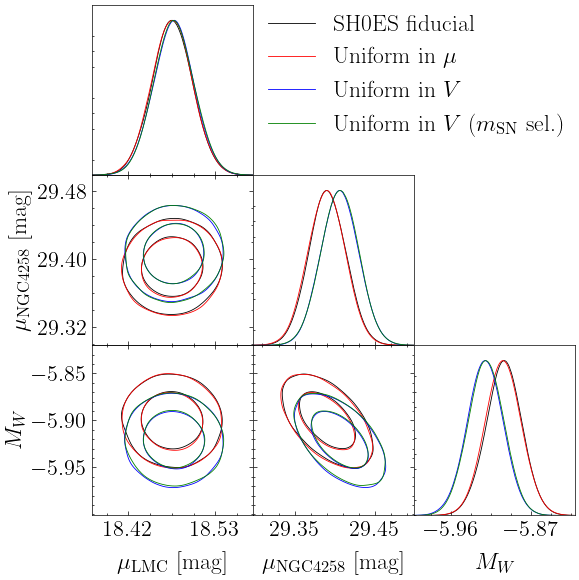

In [9]:
fnames = [
    "SH0ES_fiducial.hdf5",
    "Cepheid_distances_no_redshift_uniform_mu.hdf5",
    "Cepheid_distances_no_redshift_r2_mu.hdf5",
    "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5",
]
labels = [
    "SH0ES fiducial",
    r"Uniform in $\mu$",
    r"Uniform in $V$",
    r"Uniform in $V$ ($m_{\rm SN}$ sel.)",
]

fnames = [join(root, fname) for fname in fnames]


candel.plot_corner_from_hdf5(
    fnames,
    keys=["mu_LMC", "mu_N4258", "M_W"],
    labels=labels,
    filled=False,
    fontsize=20,
    filename="/Users/rstiskalek/Downloads/anchor_distances.pdf",
    )

### M_W calibration

In [5]:
M_HST, e_M_HST = data["M_HST"], data["e_M_HST"]
M_Gaia, e_M_Gaia = data["M_Gaia"], data["e_M_Gaia"]

print("M_HST: ", M_HST, "±", e_M_HST)
print("M_Gaia: ", M_Gaia, "±", e_M_Gaia)

M_HST:  -5.803876 ± 0.08194048719540387
M_Gaia:  -5.9034147 ± 0.025000005541368706


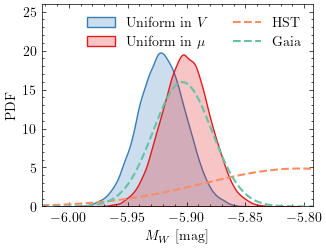

In [ ]:
M_HST, e_M_HST = data["M_HST"], data["e_M_HST"]
M_Gaia, e_M_Gaia = data["M_Gaia"], data["e_M_Gaia"]
samples_r2 = read_samples(root, "Cepheid_distances_r2_prior.hdf5", "M_W")
samples_uniform = read_samples(root, "Cepheid_distances_mu_uniform.hdf5", "M_W")


with plt.style.context("science"):
    plt.figure()
    lw = plt.rcParams["lines.linewidth"]

    # Plot KDEs instead of histograms
    sns.kdeplot(samples_r2, fill=True, label=r"Uniform in $V$", color="#377eb8", zorder=-1)
    sns.kdeplot(samples_uniform, fill=True, label=r"Uniform in $\mu$", color="#e41a1c", zorder=-1)

    # Plot Gaussian priors for HST and Gaia
    xlim = plt.xlim()
    x = np.linspace(*xlim, 500)

    plt.plot(x, norm.pdf(x, loc=M_HST, scale=e_M_HST), color="#fc8d62", label="HST", ls="--" , lw=1.5 * lw)
    plt.plot(x, norm.pdf(x, loc=M_Gaia, scale=e_M_Gaia), color="#66c2a5", label="Gaia", ls="--", lw=1.5 * lw)

    plt.xlim(*xlim)
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, ymax * 1.25)  # Increase by 20%

    plt.xlabel(r"$M_W ~ [\mathrm{mag}]$")
    plt.ylabel(r"PDF")

    plt.legend(ncols=2)
    plt.savefig("/Users/rstiskalek/Downloads/M_W_distributions.pdf", dpi=500, bbox_inches="tight")
    plt.show()


### NGC 4258 calibration

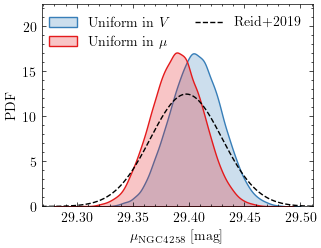

In [49]:
mean = data["mu_N4258_anchor"]
err = data["e_mu_N4258_anchor"]

samples_r2 = read_samples(root, "Cepheid_distances_no_redshift_r2_mu.hdf5", "mu_N4258")
samples_uniform = read_samples(root, "Cepheid_distances_no_redshift_uniform_mu.hdf5", "mu_N4258")

with plt.style.context("science"):
    plt.figure()
    lw = plt.rcParams["lines.linewidth"]

    # Plot KDEs instead of histograms
    sns.kdeplot(samples_r2, fill=True, label=r"Uniform in $V$", color="#377eb8", zorder=-1)
    sns.kdeplot(samples_uniform, fill=True, label=r"Uniform in $\mu$", color="#e41a1c", zorder=-1)

    # Plot Gaussian priors for HST and Gaia
    xlim = plt.xlim()
    x = np.linspace(*xlim, 500)

    plt.plot(x, norm.pdf(x, loc=mean, scale=err), color="black", label="Reid+2019", ls="--")
    # plt.plot(x, norm.pdf(x, loc=M_Gaia, scale=e_M_Gaia), color="#66c2a5", label="Gaia", ls="--", lw=1.5 * lw)

    plt.xlim(*xlim)
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, ymax * 1.25)  # Increase by 20%

    plt.xlabel(r"$\mu_{\rm NGC4258} ~ [\mathrm{mag}]$")
    plt.ylabel(r"PDF")

    plt.legend(ncols=2)
    plt.savefig("/Users/rstiskalek/Downloads/mu_NGC4258.pdf", dpi=500, bbox_inches="tight")
    plt.show()


### Cepheid-host galaxies distance comparison

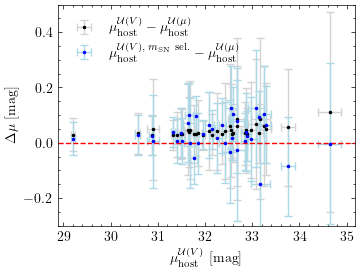

dx = 0.0445 ± 0.1456
dx = 0.0296 ± 0.1290


In [65]:
samples_r2 = read_samples(root, "Cepheid_distances_no_redshift_r2_mu.hdf5", "mu_host")
samples_r2_SN_sel = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5", "mu_host")
samples_unif = read_samples(root, "Cepheid_distances_no_redshift_uniform_mu.hdf5", "mu_host")

ntot = 37

X = {f"mu_{i}": samples_r2[:, i] for i in range(ntot)}
Y1 = {f"mu_{i}": samples_unif[:, i] for i in range(ntot)}
Y2 = {f"mu_{i}": samples_r2_SN_sel[:, i] for i in range(ntot)}

x_mean = np.asarray([np.mean(X[f"mu_{i}"]) for i in range(ntot)])
x_err = np.asarray([np.std(X[f"mu_{i}"]) for i in range(ntot)])

dy1_mean = np.asarray([np.mean(X[f"mu_{i}"]) - np.mean(Y1[f"mu_{i}"]) for i in range(ntot)])
dy1_err = np.asarray([np.sqrt(np.var(Y1[f"mu_{i}"]) + np.var(X[f"mu_{i}"])) for i in range(ntot)])

dy2_mean = np.asarray([np.mean(Y2[f"mu_{i}"]) - np.mean(Y1[f"mu_{i}"]) for i in range(ntot)])
dy2_err = np.asarray([np.sqrt(np.var(Y2[f"mu_{i}"]) + np.var(Y1[f"mu_{i}"])) for i in range(ntot)])



with plt.style.context("science"):
    plt.figure()
    plt.errorbar(x_mean, dy1_mean, xerr=x_err, yerr=dy1_err, fmt='o', color='black',
                 ecolor='lightgray',  capsize=3, ms=1.5, label=r"$\mu_{\rm host}^{\mathcal{U}(V)} - \mu_{\rm host}^{\mathcal{U}(\mu)}$")
    plt.errorbar(x_mean, dy2_mean, xerr=x_err, yerr=dy2_err, fmt='o', color='blue',
                 ecolor='lightblue',  capsize=3, ms=1.5, label=r"$\mu_{\rm host}^{\mathcal{U}(V),\,m_{\rm SN}~\mathrm{sel.}} - \mu_{\rm host}^{\mathcal{U}(\mu)}$")

    plt.axhline(0, color="red", linestyle="--", )
    plt.xlabel(r"$\mu_{\rm host}^{\mathcal{U}(V)} ~ [\mathrm{mag}]$")
    plt.ylabel(r"$\Delta \mu ~ [\mathrm{mag}]$")
    plt.ylim(-0.3, 0.5)
    plt.legend()

    plt.tight_layout(pad=0)
    plt.savefig("/Users/rstiskalek/Downloads/mu_host.pdf", bbox_inches='tight')

    plt.show()


print(f"dx = {dy1_mean.mean():.4f} ± {dy1_err.mean():.4f}")
print(f"dx = {dy2_mean.mean():.4f} ± {dy2_err.mean():.4f}")

In [75]:
z = 10**(dy2_mean / 5) - 1
low, med, high = np.percentile(z * 100, [16, 50, 84])

med, med - low, high - med

(1.2038707733154297, 1.3476011753082275, 3.2323966026306152)

### C15 all-parameters

Cepheid_H0_C15_MNR.hdf5: H0, M_W, Vext, Vext_b, Vext_ell, Vext_mag, Z_W, b_W, beta, dZP, mean_OH_all, mean_OH_per_host, mean_logP_all, mean_logP_per_host, mean_std_OH, mean_std_logP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v, std_OH_all, std_OH_per_host, std_logP_all, std_logP_per_host
Removed no burn in
2025-07-04 08:30:36 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/C15_corner.pdf


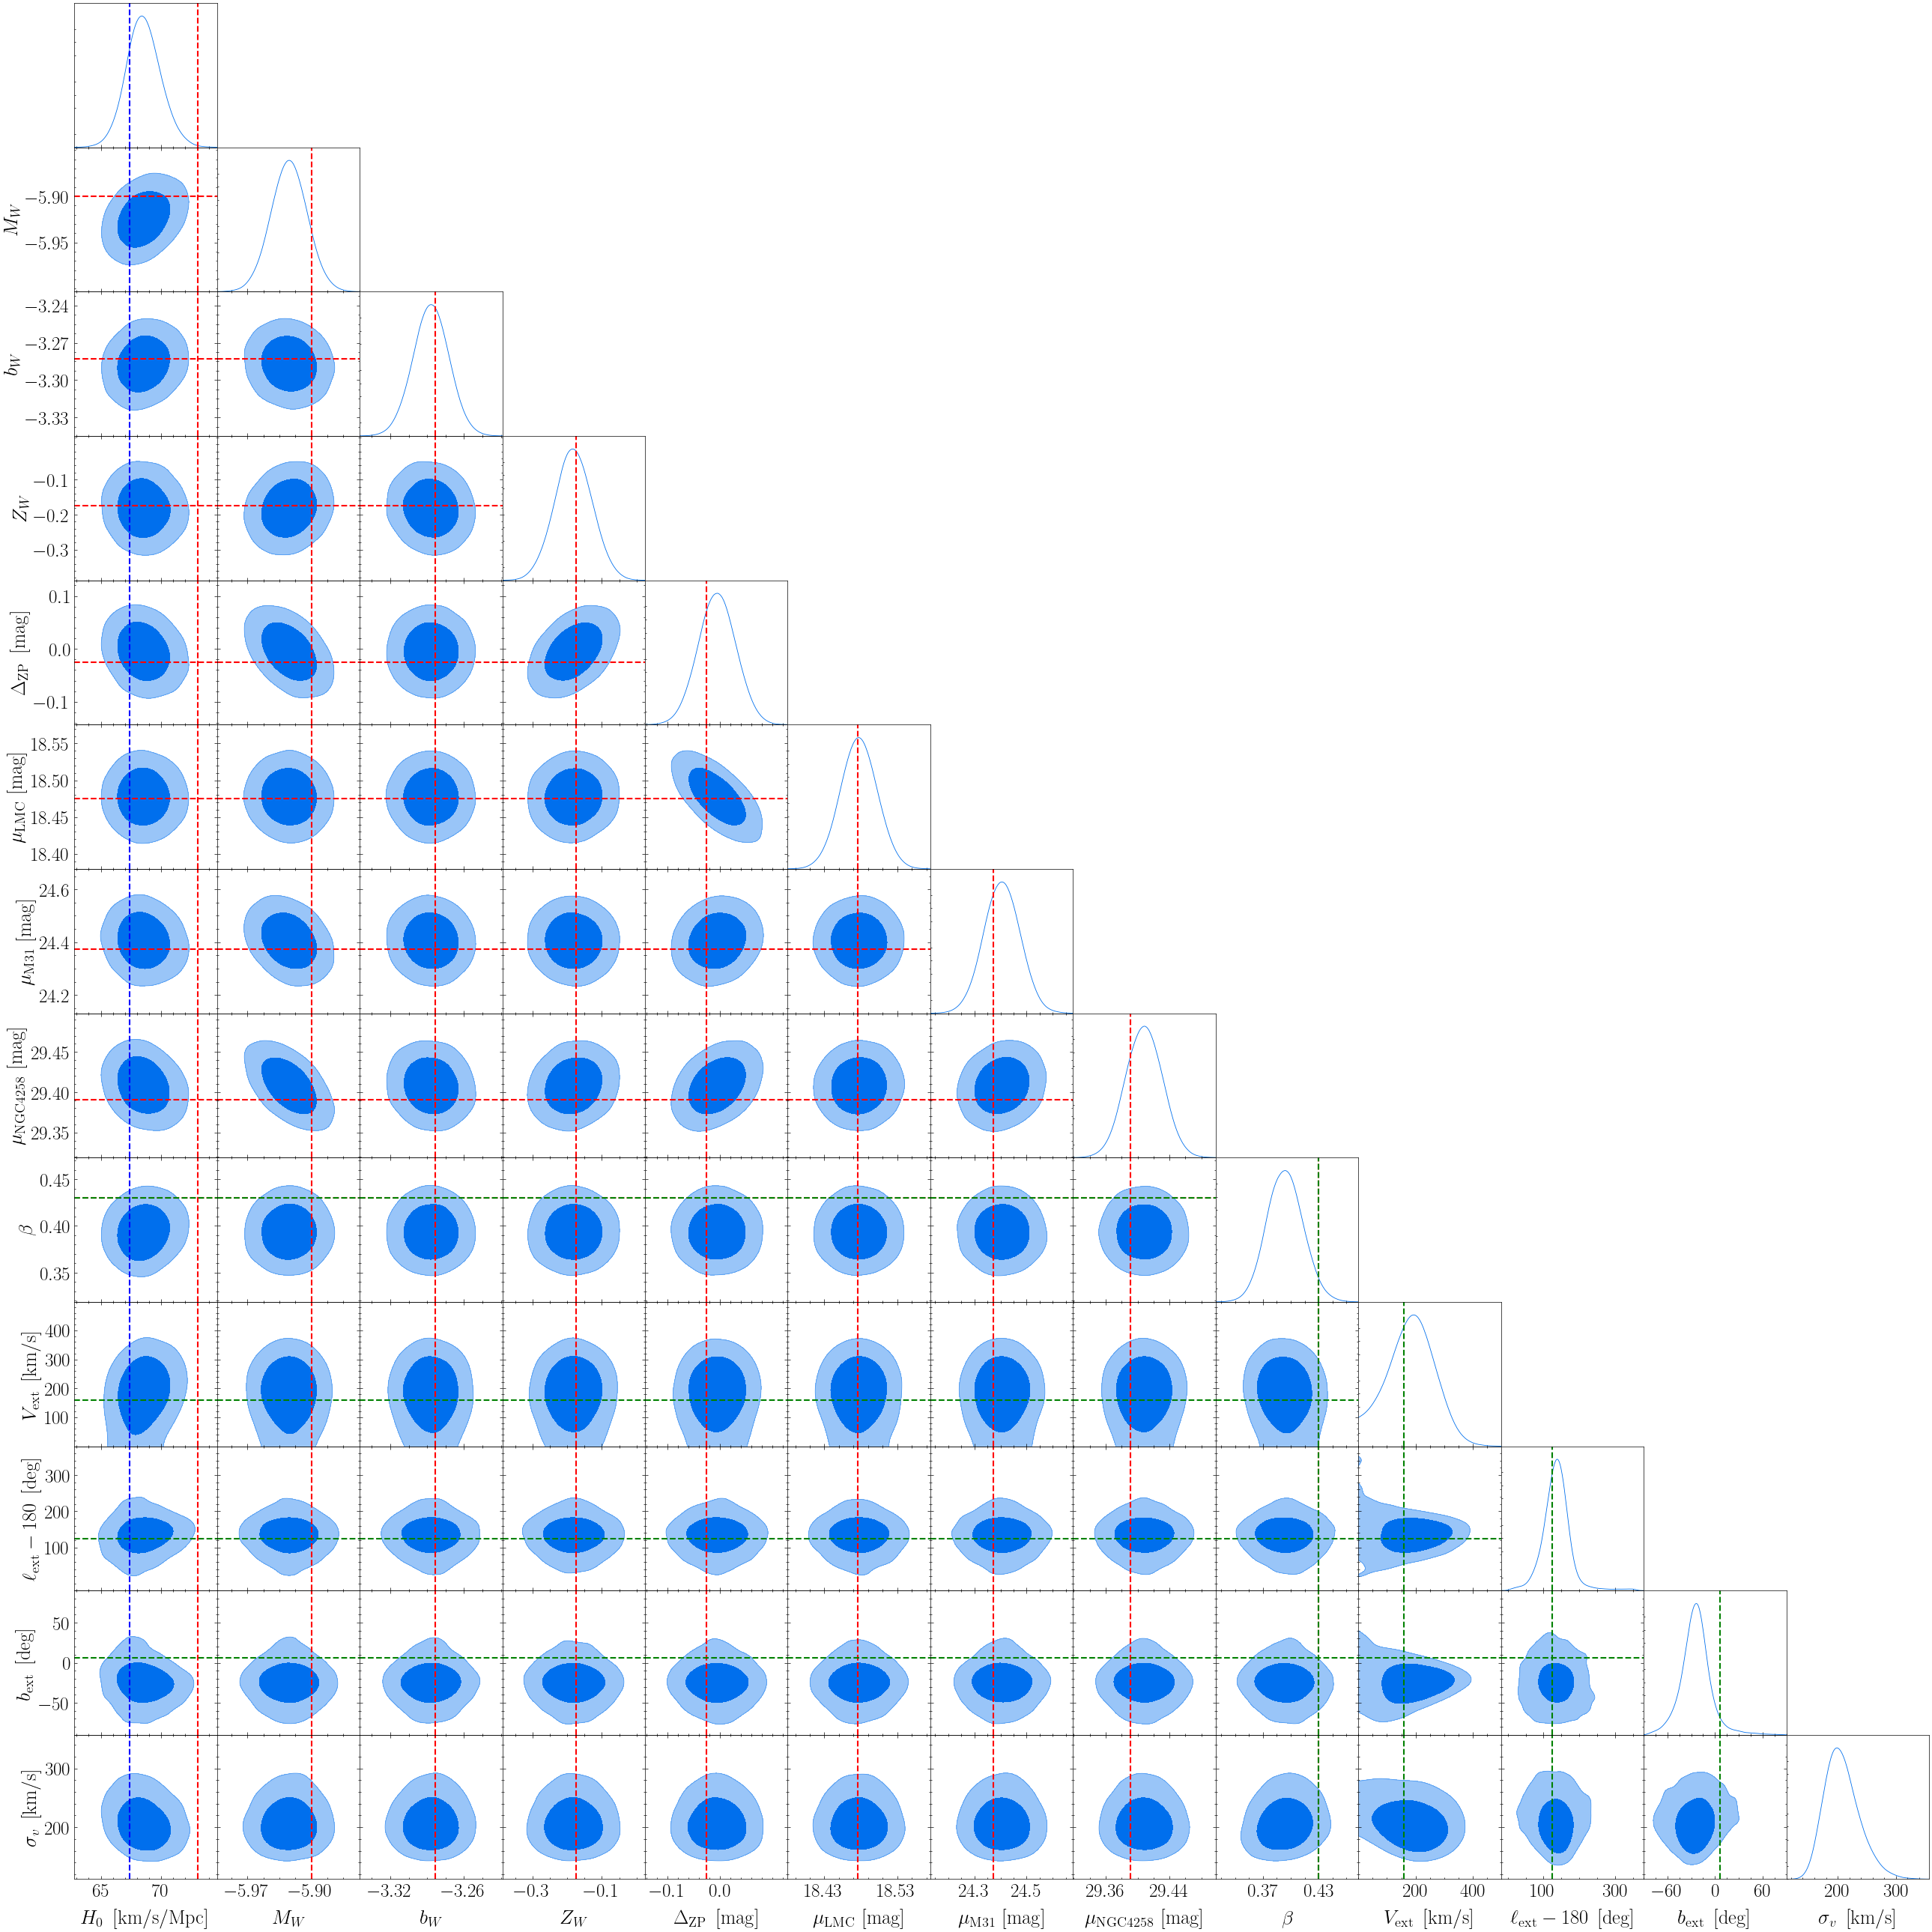

In [5]:
fnames = [
    "Cepheid_H0_C15_MNR.hdf5",
    ]

labels = None

fnames = [join(root, fname) for fname in fnames]

truths_SH0ES = {"H0": 73.04, "M_W": -5.8999543, "b_W": -3.2831473,
          "Z_W": -0.17501639, "dZP": -0.025033418, "mu_LMC": 18.475368,
          "mu_N4258": 29.390965, "mu_M31": 24.373648, "beta": 0.43}
truths_Planck = {"H0": 67.4,}
truths_Carrick = {"beta": 0.43, "Vext_mag": 159, "Vext_ell": 304 - 180, "Vext_b": 6}

truths = [
    {"dict": truths_SH0ES, "color": "red"},
    {"dict": truths_Planck, "color": "blue",},
    {"dict": truths_Carrick, "color": "green", "label": "Carrick+2023"},
]


candel.plot_corner_from_hdf5(
    fnames,
    keys=["H0", "M_W", "b_W", "Z_W", "dZP", "mu_LMC", "mu_M31", "mu_N4258", "beta", "Vext_mag", "Vext_ell", "Vext_b", "sigma_v"],
    labels=labels,
    apply_ell_offset=True,
    ell_range=[None, None],
    filename="/Users/rstiskalek/Downloads/C15_corner.pdf",
    fontsize=22,
    truths=truths,
    )

### Comparison of all inferred $H_0$ values

In [5]:
fnames = [
    "Cepheid_H0_C15.hdf5",
    # "Cepheid_H0_PV_covmat.hdf5",
    # "Cepheid_H0_Vext_sigma_v.hdf5",
    # "Cepheid_H0_sigma_v.hdf5",
    # "Cepheid_H0_PV_covmat_scaled.hdf5",
]
labels = [
    r"PVs from Carrick+2015, $\boldsymbol{V}_{\rm ext}$, diagonal covariance",
    # r"$\langle V_{\rm pec}\rangle = 0$, $\Lambda$CDM covariance",
    # r"$\boldsymbol{V}_{\rm ext}$, diagonal covariance",
    # r"$\langle V_{\rm pec}\rangle = 0$, diagonal covariance",
    # r"Cepheids only (uniform in volume prior)",
    # r"Cepheids only (uniform in $\mu$ prior)",
    # r"Cepheids full",
]

samples = [read_samples(root, fname, "H0") for fname in fnames]

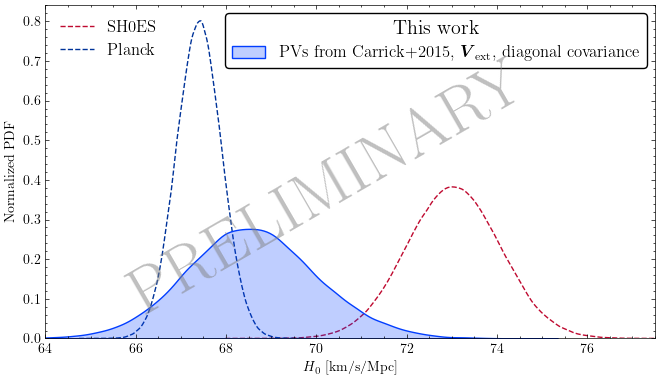

In [6]:
fig_width = 6.8  # in inches
fig_height = 4

filtered_palette = sns.color_palette("bright")
# filtered_palette = set1_palette[2:]  # skip red (0) and blue (1)

with plt.style.context("science"):
    plt.figure(figsize=(fig_width, fig_height))

    for i in range(len(samples)):
        sns.kdeplot(
            samples[i],
            label=labels[i],
            fill=True,
            color=filtered_palette[i % len(filtered_palette)]
        )

    sns.kdeplot(
        norm(73.04, 1.04).rvs(size=500000),
        label="SH0ES",
        fill=False,
        # alpha=0.2,
        ls="--",
        color="#BF0A30",
        zorder=-1,
    )
    sns.kdeplot(
        norm(67.4, 0.5).rvs(size=500000),
        label="Planck",
        fill=False,
        # alpha=0.2,
        ls="--",
        color="#003399",
        zorder=-1,
    )

    plt.text(
    0.5, 0.5, "PRELIMINARY",
    fontsize=48, color='gray', alpha=0.5,
    ha='center', va='center', zorder=10,
    transform=plt.gcf().transFigure, rotation=30)

    plt.xlabel(r"$H_0 ~ [\mathrm{km}/\mathrm{s}/\mathrm{Mpc}]$")
    plt.ylabel("Normalized PDF")
    # plt.legend(ncol=1, fontsize="large")

    ax = plt.gca()

    # Get all handles and labels
    handles, labels_all = ax.get_legend_handles_labels()

    # Separate by label
    main_handles = []
    main_labels = []
    ref_handles = []
    ref_labels = []

    for h, l in zip(handles, labels_all):
        if l in ["SH0ES", "Planck"]:
            ref_handles.append(h)
            ref_labels.append(l)
        else:
            main_handles.append(h)
            main_labels.append(l)

    legend1 = ax.legend(
        main_handles, main_labels,
        loc="upper right",
        fontsize="large",
        title="This work",
        title_fontsize="x-large",
        frameon=True,
        edgecolor='black',
        facecolor='white',
        fancybox=True,
        framealpha=1
    )
    ax.add_artist(legend1)
    ax.legend(ref_handles, ref_labels, loc="upper left", fontsize="large")


    plt.xlim(64, 77.5)
    plt.tight_layout()
    plt.savefig("/Users/rstiskalek/Downloads/H0_comparison.pdf", dpi=500, bbox_inches="tight")
    plt.show()

In [100]:
# x = read_samples(root, "Cepheid_distances_r2_prior.hdf5", "mu_N4258")
# x = read_samples(root, "Cepheid_distances_mu_uniform.hdf5", "mu_N4258")
x = read_samples(root, "Cepheid_H0_C15.hdf5", "H0")

x.mean(), x.std()

(68.5731, 1.4567436)

In [ ]:
# With full covariance: (67.88053, 2.8552945)
# With high k covariance: (67.144714, 1.7662146)
# sigma_v only: (67.08489, 1.8044024)



In [90]:
x[:, 0].std()

0.039587677

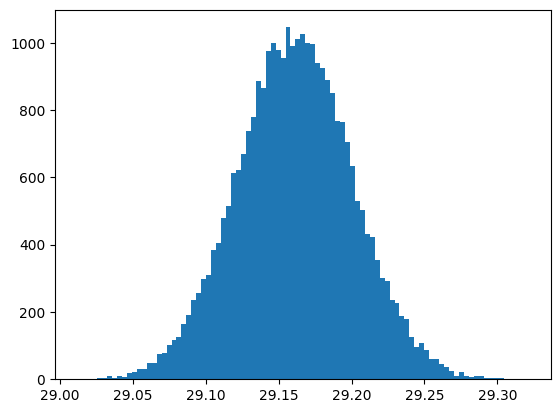

In [88]:
plt.figure()
plt.hist(x[:, 0], bins="auto")
plt.show()

In [63]:
29.387 + 0.00856

29.39556

In [41]:
(29.406357 - 29.390036)  / 0.023164261

0.7045767615898199

In [27]:
(29.390036, 0.02320611)

{'A_covmat': array([1.0068883, 1.2296764, 1.050108 , ..., 1.1200849, 1.2453475,
        1.0074599], dtype=float32),
 'H0': array([66.251144, 68.68274 , 68.09114 , ..., 68.988716, 66.54725 ,
        67.010284], dtype=float32),
 'M_W': array([-5.887863 , -5.969678 , -5.955756 , ..., -5.957978 , -5.940194 ,
        -5.9233484], dtype=float32),
 'Z_W': array([-0.14601648, -0.24969459, -0.17832446, ..., -0.24659014,
        -0.24251056, -0.20167792], dtype=float32),
 'b_W': array([-3.2939887, -3.2818975, -3.2787418, ..., -3.2705421, -3.276505 ,
        -3.291234 ], dtype=float32),
 'dZP': array([-0.04682525,  0.03513318,  0.0401937 , ...,  0.01574068,
         0.01761054,  0.02050023], dtype=float32),
 'mu_LMC': array([18.492857, 18.466623, 18.474642, ..., 18.470268, 18.448547,
        18.451937], dtype=float32),
 'mu_M31': array([24.364208, 24.361563, 24.330856, ..., 24.370644, 24.419823,
        24.460966], dtype=float32),
 'mu_N4258': array([29.403936, 29.460613, 29.409685, ..., 29.44182

In [ ]:
from scipy.stats import norm
import posterior_agreement

# x = read_samples(root, "Cepheid_H0_Vext_sigma_v.hdf5", "H0")
x = norm(72.59, 1.71).rvs(50000)
H0_planck = norm(67.4, 0.5).rvs(50000)
H0_SH0ES = norm(73.04, 1.04).rvs(50000)

print(x.mean(), x.std())

chains = (H0_SH0ES, x)
agreement_1d = posterior_agreement.compute_agreement(chains)
print("SH0ES: p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

chains = (H0_planck, x)
agreement_1d = posterior_agreement.compute_agreement(chains)
print("Planck: p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

72.60269827917116 1.7002772419276986
SH0ES: p-value 0.839, corresponding to 0.2026 sigmas
Planck: p-value 0.430, corresponding to 0.7892 sigmas
